# Cleanlab Mnist Example

This notebook contains an end-to-end demostration of Dioptra that can be run on any modern laptop.
Please see the [example README](README.md) for instructions on how to prepare your environment for running this example.

### Setup

Below we import the necessary Python modules and ensure the proper environment variables are set so that all the code blocks will work as expected,

In [1]:
EXPERIMENT_NAME = "cleanlab_exp"
EXPERIMENT_DESC = "experimenting with cleanlab cleaning techniques with a classifier trained on MNIST"
QUEUE_NAME = 'tensorflow_cpu'
QUEUE_DESC = 'Tensorflow CPU Queue'
MODEL_NAME = "mnist_classifier"

# Default address for accessing the RESTful API service
RESTAPI_ADDRESS = "http://localhost:5000"

# Default address for accessing the MLFlow Tracking server
MLFLOW_TRACKING_URI = "http://localhost:35000"

In [2]:
# Import packages from the Python standard library
import importlib.util
import json
import os
import sys
import pprint
import time
import warnings
from IPython.display import display, clear_output
import logging
import structlog
from pathlib import Path

# Filter out warning messages
warnings.filterwarnings("ignore")
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.ERROR),
)

from dioptra.client import connect_json_dioptra_client, connect_response_dioptra_client, select_files_in_directory, select_one_or_more_files

# Set DIOPTRA_API variable if not defined, used to connect to RESTful API service
if os.getenv("DIOPTRA_API") is None:
    os.environ["DIOPTRA_API"] = RESTAPI_ADDRESS

# Set MLFLOW_TRACKING_URI variable, used to connect to MLFlow Tracking service
if os.getenv("MLFLOW_TRACKING_URI") is None:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI

In [3]:
def wait_for_job(job, job_name, quiet=False):
    n = 0
    while job['status'] not in ['finished', 'failed']:
        job = client.jobs.get_by_id(job['id'])
        time.sleep(1)
        if not quiet:
            clear_output(wait=True)
            display("Waiting for job." + "." * (n % 3) )
        n += 1
    if not quiet:
        if job['status'] == 'finished':
            clear_output(wait=True)
            display(f"Job finished. Starting {job_name} job.")
        else:
            raise Exception("Previous job failed. Please see tensorflow-cpu logs for details.")
    

### Dataset

We obtained a copy of the MNIST dataset when we ran `download_data.py` script. If you have not done so already, see [How to Obtain Common Datasets](https://pages.nist.gov/dioptra/getting-started/acquiring-datasets.html).
The training and testing images for the MNIST dataset are stored within the `/dioptra/data/Mnist` directory as PNG files that are organized into the following folder structure,

    Mnist
    ├── testing
    │   ├── 0
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   ├── 4
    │   ├── 5
    │   ├── 6
    │   ├── 7
    │   ├── 8
    │   └── 9
    └── training
        ├── 0
        ├── 1
        ├── 2
        ├── 3
        ├── 4
        ├── 5
        ├── 6
        ├── 7
        ├── 8
        └── 9

The subfolders under `training/` and `testing/` are the classification labels for the images in the dataset.
This folder structure is a standardized way to encode the label information and many libraries can make use of it, including the Tensorflow library that we are using for this particular demo.

### Login to Dioptra and setup RESTAPI client

To connect with the endpoint, we will use a client class defined in the `examples/scripts/client.py` file that is able to connect with the Dioptra RESTful API using the HTTP protocol.
We connect using the client below.
The client uses the environment variable `DIOPTRA_API`, which we configured at the top of the notebook, to figure out how to connect to the Dioptra RESTful API.

In [4]:
#client = connect_response_dioptra_client()
client = connect_json_dioptra_client()

It is necessary to login to the RESTAPI to be able to perform any functions. Here we create a user if it is not created already, and login with it.

In [5]:
try:
    client.users.create(
        username='user',
        email='email',
        password='pass'
    )
except:
    pass # ignore if user exists already

client.auth.login(
    username='user',
    password='pass'
)


{'username': 'user', 'status': 'Login successful'}

### Upload all the entrypoints

In [6]:
# import from local filesystem
# logging.basicConfig(level=logging.DEBUG) # Sets the root logger level

response = client.workflows.import_resources(group_id=1,
                                             source=select_files_in_directory("../extra/", recursive=True),
                                             config_path="dioptra.toml",
                                             resolve_name_conflicts_strategy="overwrite",
                                            )
resources = response["resources"]



train_ep = resources["entrypoints"]["Train"]
metrics_ep = resources["entrypoints"]["Metrics"]
clean_ep = resources["entrypoints"]["Clean"]
poison_ep = resources["entrypoints"]["Poison"]
filter_ep = resources["entrypoints"]["Filter"]
train_mlflow_ep = resources["entrypoints"]["Train from MLFlow"]
predict_ep = resources["entrypoints"]["Predict"]
metrics_ep = resources["entrypoints"]["Metrics"]

entrypoints = [ train_ep, metrics_ep, clean_ep, poison_ep, filter_ep, train_mlflow_ep, predict_ep, metrics_ep ]

In [7]:
try:
    experiment = client.experiments.create(group_id=1, name=EXPERIMENT_NAME, description=EXPERIMENT_DESC)
except:
    experiment = client.experiments.get(search=f"name:'{EXPERIMENT_NAME}'")["data"][0]

try:
    queue = client.queues.create(group_id=1, name=QUEUE_NAME, description=QUEUE_DESC)
except:
    queue = client.queues.get(search=f"name:'{QUEUE_NAME}'")["data"][0]

experiment_id = experiment['id']
queue_id = queue['id']

client.experiments.entrypoints.create(experiment_id=experiment_id, entrypoint_ids=entrypoints)

for entrypoint in entrypoints:
    client.entrypoints.queues.create(entrypoint_id=entrypoint, queue_ids=[queue_id])



### Helper functions to submit jobs

In [8]:
def run_job(experiment_id, queue_id, ep, title, prev_job_id=False, latest_model=False, args=None, prev_job=None, job_time_limit='1h'):
    args = {} if args is None else args
    if prev_job is not None:
        wait_for_job(prev_job, title, quiet=False)
    if prev_job_id and 'id' in prev_job.keys():
        args['job_id'] = str(prev_job['id'])
    if latest_model:
        args['model_name'] = MODEL_NAME 
        args['model_version'] = str(-1)
    job = client.experiments.jobs.create(
        experiment_id=experiment_id,
        description=f"{title} job for {experiment_id}",
        queue_id=queue_id,
        entrypoint_id=ep,
        values=args,
        timeout=job_time_limit
    )
    return job


In [9]:
def poison(
    experiment_id,
    queue_id,
    poison_ep,
    percent = "0.3",
    poison_dir="/dioptra/data/Mnist/training",
    dd="poisoned_data",
    tn="poisoned_data.tar.gz",
    target="0",
    eps="0.3",
    eps_step="0.1",
    max_iter="100",
    clean_label="True",
    job_time_limit='1h'
):
    arg_dict = {
        "percent_poison": percent,
        "poison_dir": poison_dir,
        "adv_data_dir": dd,
        "adv_tar_name": tn,
        "target_idx": target,
        "eps": eps,
        "eps_step": eps_step,
        "max_iter": max_iter,
        "clean_label": clean_label,
    }
    poison_job = run_job(experiment_id, queue_id, poison_ep, "poison", latest_model=False, args=arg_dict, job_time_limit=job_time_limit)
    return poison_job

In [10]:
def clean(experiment_id, queue_id, clean_ep, prev_job, job_time_limit='1h'):
    clean_job = run_job(
        experiment_id,
        queue_id,
        clean_ep,
        "clean",
        prev_job_id=True,
        latest_model=True,
        args=None,
        prev_job=prev_job,
        job_time_limit=job_time_limit
    )
    return clean_job

In [11]:
def filter_data(experiment_id, queue_id, filter_ep, prev_job, job_time_limit='1h'):
    filter_job = run_job(
        experiment_id,
        queue_id,
        filter_ep,
        "filter_data",
        prev_job_id=True,
        latest_model=False,
        args=None,
        prev_job=prev_job,
        job_time_limit=job_time_limit
    )
    return filter_job

In [12]:
def train_mlflow(experiment_id, queue_id, train_mlflow_ep, data_dir, tar_name, model_name, prev_job, epochs = "3", job_time_limit='1h'):
    arg_dict = {
        "data_dir": data_dir,
        "tar_name": tar_name,
        "register_model_name": model_name,
        "epochs": epochs,
    } 
    
    train_job = run_job(
        experiment_id,
        queue_id,
        train_mlflow_ep,
        "train_mlflow",
        prev_job_id=True,
        latest_model=False,
        args=arg_dict,
        prev_job=prev_job,
        job_time_limit=job_time_limit,
    )
    return train_job

In [13]:
def predict(experiment_id, queue_id, predict_ep, prev_job, tn, dd, model_name, job_time_limit='1h'):
    arg_dict = {
        "tar_name": tn,
        "data_dir": dd,
        "model_name": model_name,
        "model_version": "-1",
        #"record_actual_class": str(True), # add a column 'actual' representing the class with the highest probability
        #"record_target_class": str(True)  # add a column 'target' representing the original class of the image
    } # Note: using both actual and target above removes the need to load the original dataset during metrics calculation
    predict_job = run_job(
        experiment_id,
        queue_id,
        predict_ep,
        "predict",
        prev_job_id=True,
        latest_model=False,
        args=arg_dict,
        prev_job=prev_job,
        job_time_limit=job_time_limit
    )
    return predict_job

In [14]:
def measure(experiment_id, queue_id, measure_ep, prev_job, job_time_limit='1h'):
    metrics_job = run_job(
        experiment_id,
        queue_id,
        measure_ep,
        "metrics",
        prev_job_id=True,
        args={},
        prev_job=prev_job,
        job_time_limit=job_time_limit)
    return metrics_job

In [15]:
from mlflow.tracking import MlflowClient
from uuid import UUID

def get_metrics(job):
    wait_for_job(job, 'metrics', quiet=True)
    return client.jobs.get_metrics_by_id(job_id=job['id'])

### Training a Regular MNIST LeNet Model

This trains a MNIST LeNet model

In [16]:
job_time_limit = '1h'

training_job = client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"training job for {experiment_id}", 
    queue_id=queue_id,
    entrypoint_id=train_ep, 
    values={"epochs":"3"}, 
    timeout=job_time_limit
)

### Poisoning a Dataset and Training a Poisoned Model

The next few jobs poison a dataset and train a model on the poisoned dataset.

#### Poisoning Attack

In [17]:
poisoning = poison(
    experiment_id,
    queue_id,
    poison_ep,
    percent="0.01",
    eps="5",
    eps_step="0.05",
    max_iter = "1000",
    clean_label= "True",
    job_time_limit='10h'
)

#### Training a Poisoned Model

In [18]:
wait_for_job(poisoning, "train_mlflow")
poison_model = train_mlflow(
    experiment_id,
    queue_id,
    train_mlflow_ep,
    "poisoned_data",
    "poisoned_data.tar.gz",
    "poisoned_mnist_classifier",
    poisoning,
    epochs="10",
)

'Job finished. Starting train_mlflow job.'

### Cleaning and Filtering

We then run Cleanlab's analysis on the poisoned dataset, filters out all potentially problematic data, and trains a new model on the result.

#### Cleanlab Report

This job uses Cleanlab to identify potentially problematic dataset members and create an artifact in Dioptra with this information.

In [19]:
cleaning = clean(experiment_id, queue_id, clean_ep, poisoning, job_time_limit='1h')

'Job finished. Starting clean job.'

#### Filter Dataset

This job takes the list of identified problematic dataset members from the previous job and removes them from the dataset.

In [20]:
args = {
    "job_id" : str(cleaning['id']),
    "dir_job_id" : str(poisoning['id'])
}
filtering = client.experiments.jobs.create(
        experiment_id=experiment_id,
        description=f"filtering job for {experiment_id}",
        queue_id=queue_id,
        entrypoint_id=filter_ep,
        values=args,
        timeout='1h'
)

#### Training on filtered data

In [21]:
wait_for_job(filtering, "train_mlflow")
filtered_model = train_mlflow(
    experiment_id,
    queue_id,
    train_mlflow_ep,
    "cleaned_data",
    "cleaned_data.tar.gz",
    "cleaned_mnist_classifier",
    filtering,
    epochs="30",
)

'Job finished. Starting train_mlflow job.'

### Metrics

Collection of metrics on each of our three models

In [22]:
poisoned_test_dir = poison(
    experiment_id, 
    queue_id, 
    poison_ep,
    percent="0.99", 
    poison_dir="/dioptra/data/Mnist/testing", 
    dd="poisoned_testing_data",
    tn="poisoned_testing_data.tar.gz", 
    target="4",
    eps="0.3",
    eps_step=".1",
    max_iter="100",
    clean_label="False",
    job_time_limit='3h',
)

In [23]:
wait_for_job(training_job, "predict")
predict_norm = predict(
    experiment_id,
    queue_id,
    predict_ep,
    poisoned_test_dir,
    tn="poisoned_testing_data.tar.gz",
    dd="poisoned_testing_data",
    model_name="mnist_classifier",
    job_time_limit='1h',
)
measure_norm = measure(experiment_id, queue_id, metrics_ep, predict_norm)

'Job finished. Starting metrics job.'

In [24]:
wait_for_job(poison_model, "predict")
predict_poisoned = predict(
    experiment_id,
    queue_id,
    predict_ep,
    poisoned_test_dir,
    tn="poisoned_testing_data.tar.gz",
    dd="poisoned_testing_data",
    model_name="poisoned_mnist_classifier",
    job_time_limit='1h',
)
measure_poisoned = measure(experiment_id, queue_id, metrics_ep, predict_poisoned)

'Job finished. Starting metrics job.'

In [25]:
wait_for_job(filtered_model, "predict")
predict_cleaned = predict(
    experiment_id,
    queue_id,
    predict_ep,
    poisoned_test_dir,
    tn="poisoned_testing_data.tar.gz",
    dd="poisoned_testing_data",
    model_name="cleaned_mnist_classifier",
    job_time_limit='1h',
)
measure_cleaned = measure(experiment_id, queue_id, metrics_ep, predict_cleaned)

'Job finished. Starting metrics job.'

### Display Metrics

In [26]:
import pprint
metrics = {
    "norm on testing data": get_metrics(measure_norm),
    "poisoned on testing data": get_metrics(measure_poisoned),
    "poisoned then cleaned on testing data": get_metrics(measure_cleaned),
    "norm": get_metrics(training_job),
    "poisoned": get_metrics(poison_model),
    "poisoned then cleaned": get_metrics(filtered_model),
}

pp = pprint.PrettyPrinter(depth=4)
print("Model Metric")
pp.pprint(metrics)

Model Metric
{'norm': [{'name': 'training_time_in_minutes', 'value': 2.0644861000000003},
          {'name': 'accuracy', 'value': 0.9850000143051147},
          {'name': 'auc', 'value': 0.9997453093528748},
          {'name': 'loss', 'value': 0.04106629639863968},
          {'name': 'precision', 'value': 0.9875451922416687},
          {'name': 'recall', 'value': 0.9832000136375427}],
 'norm on testing data': [{'name': 'accuracy', 'value': 0.9849},
                          {'name': 'roc_auc', 'value': 0.9916091232591189}],
 'poisoned': [{'name': 'training_time_in_minutes', 'value': 8.342077166666666},
              {'name': 'accuracy', 'value': 0.9901000261306763},
              {'name': 'auc', 'value': 0.9992064237594604},
              {'name': 'loss', 'value': 0.0354672335088253},
              {'name': 'precision', 'value': 0.9907843470573425},
              {'name': 'recall', 'value': 0.9890999794006348}],
 'poisoned on testing data': [{'name': 'accuracy', 'value': 0.309},
       

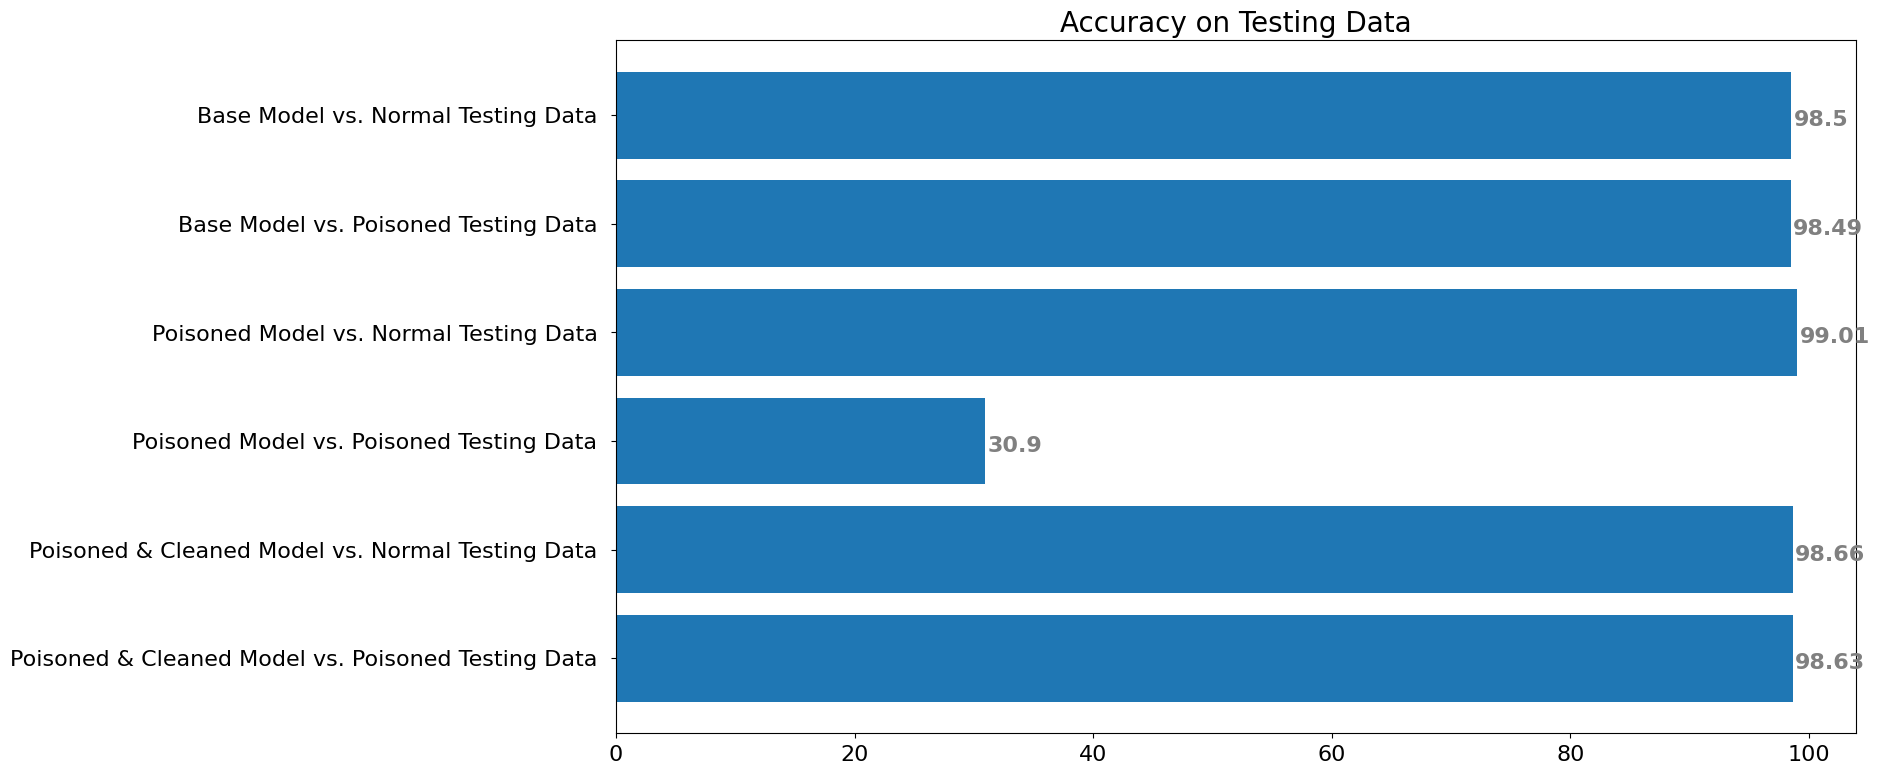

In [27]:
import numpy as np
import matplotlib.pyplot as plt 

scenarios = {
    'norm': 'Base Model vs. Normal Testing Data',
    'norm on testing data': 'Base Model vs. Poisoned Testing Data',
    'poisoned': 'Poisoned Model vs. Normal Testing Data',
    'poisoned on testing data': 'Poisoned Model vs. Poisoned Testing Data',
    'poisoned then cleaned': 'Poisoned & Cleaned Model vs. Normal Testing Data',
    'poisoned then cleaned on testing data': 'Poisoned & Cleaned Model vs. Poisoned Testing Data',
}
names = [scenarios[k] for k in scenarios.keys()]
values = [[job_metric['value'] * 100 for job_metric in metrics[k] if job_metric['name'] == 'accuracy'][0] for k in scenarios.keys()]


fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(names, values)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5, labelsize=16)
ax.yaxis.set_tick_params(pad = 10, labelsize=16)

# Show top values 
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 16, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Accuracy on Testing Data',
             loc ='center', fontsize = 20,)

# Show Plot
plt.show()